In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()

# reflect the tables
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
# Print all of the classes mapped to the Base
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
from sqlalchemy import select

Measurement = Base.classes.measurement
Station = Base.classes.station 

print(select(Measurement))
print(select(Station))

SELECT measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs 
FROM measurement
SELECT station.id, station.station, station.name, station.latitude, station.longitude, station.elevation 
FROM station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

first_row = session.query(Measurement).first()
first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11dde0c10>,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1}

In [9]:
for row in session.query(Measurement.date).limit(10).all():
    print(row)

('2010-01-01',)
('2010-01-02',)
('2010-01-03',)
('2010-01-04',)
('2010-01-06',)
('2010-01-07',)
('2010-01-08',)
('2010-01-09',)
('2010-01-10',)
('2010-01-11',)


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date.date

'2017-08-23'

In [11]:
Base.metadata.tables

FacadeDict({'measurement': Table('measurement', MetaData(), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

In [12]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [13]:
measurement_columns = inspector.get_columns('measurement')
for each_column in measurement_columns:
    print(each_column['name'], each_column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
station_columns = inspector.get_columns('station')
for each_column in measurement_columns:
    print(each_column['name'], each_column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


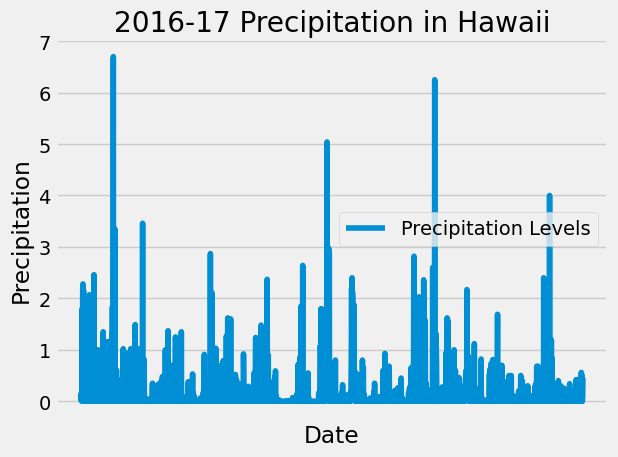

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date (recent_date) in data set.
last_test = pd.to_datetime(recent_date.date)
first_test = last_test - timedelta(days=365)

first_date = dt.date(first_test.year, first_test.month, first_test.day)
last_date = dt.date(last_test.year, last_test.month, last_test.day)

# Perform a query to retrieve the data and precipitation scores
precipitation_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= first_date).\
    order_by(Measurement.date.asc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_year_df = pd.DataFrame(precipitation_year, columns=['Date', 'Precipitation'])
precipitation_year_df = precipitation_year_df.fillna(0)

# Sort the dataframe by date
sorted_df = precipitation_year_df.sort_values(by='Date')
sorted_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
plt.style.use('fivethirtyeight')

precipitation_year_df.plot()
plt.legend(['Precipitation Levels'])
plt.xticks([])
plt.title('2016-17 Precipitation in Hawaii')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.tight_layout()
plt.savefig('Images/Precipitation_1year.png')
plt.show()


# Some prints used during this analysis
#last_test
#type(Measurement.date)
#precipitation_year
#precipitation_year_df


In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
summ_stats = precipitation_year_df.describe()
summ_stats

,Precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()
total_stations

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
#count = func.count(Measurement.station)
stations_count = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

stations_count = {station: count for station, count in stations_count}

for each_station,counter in stations_count.items():
    print(each_station,counter)

stations_list = list(stations_count)
most_active = stations_list[0]
most_active_count = stations_count[most_active]

print(f'The most active station is {most_active} with a total of registers of {most_active_count}')



USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511
The most active station is USC00519281 with a total of registers of 2772


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
all_tobs = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
most_active_stats = all_tobs.filter(Measurement.station == most_active).all()
print(most_active_stats)


[(54.0, 85.0, 71.66378066378067)]


In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_year = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.date >= first_date).filter(Measurement.date <= last_date).\
    filter(Measurement.station == most_active).all()

tobs_year_df = pd.DataFrame(tobs_year, columns=['Date','TOBS'])
tobs_year_df = tobs_year_df.set_index('Date')

tobs_year_df.sort_values(by='Date')
tobs_year_df.head()

,TOBS
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


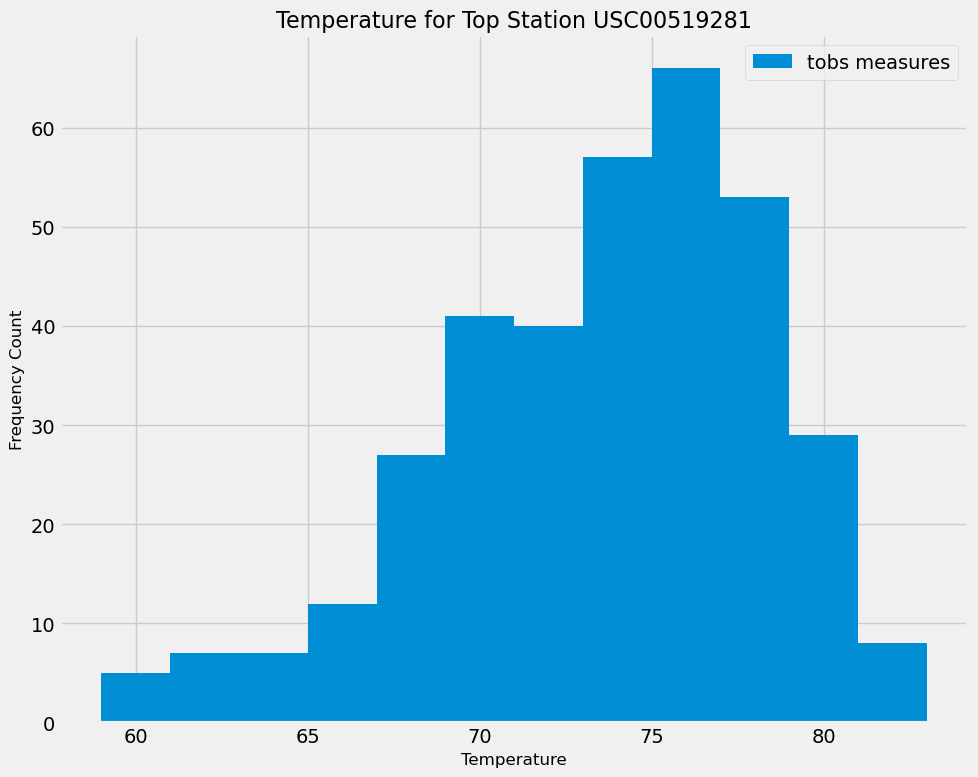

In [21]:
plt.figure(figsize=(10,8))
plt.hist(tobs_year_df['TOBS'].values,bins=12)
plt.legend(['tobs measures'],loc='best')
plt.ylabel('Frequency Count',size=12)
plt.xlabel('Temperature',size=12)
plt.title(f'Temperature for Top Station {most_active}',size=16)
plt.tight_layout()
plt.savefig('Images/YearlyTOBS.png')
plt.show()

# Close Session

In [22]:
# Close Session
session.close()